In [47]:
import requests
def get_usgs_gw1(state, start_year, end_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/gwlevels/?format=json&siteStatus=active&startDT=%s-01-01&endDT=%s-12-31&siteType=GW&parameterCd=72019&%s" % (start_year, end_year, where)
    #try:
    req = requests.post(waterservices) 
    return req.json()
    #except:
        #return {"error": "Error on USGS access"}

# get daily groundwater value for stations in a state (1900-present) = this gets daily means
def get_usgs_gw2(state, start_year):
    where = "stateCd={}".format(state)
    waterservices = "https://waterservices.usgs.gov/nwis/dv/?format=json&siteStatus=active&startDT=%s-01-01&endDT=2024-01-03&siteType=GW&parameterCd=72019&%s" % (start_year, where)
    try:
        req = requests.post(waterservices) 
        return req.json()
    except:
        return {"error": "Error on USGS access 2"}

In [62]:
# Date collection

def get_gw_date(data, site, index):
    return data["value"]["timeSeries"][site]["values"][0]["value"][index]["dateTime"][0:10]
# Value
def get_gw_value(data, site, index):
    return float(data["value"]["timeSeries"][site]["values"][0]["value"][index]["value"])
# Site name
def get_site(data, site):
    return data["value"]["timeSeries"][site]["sourceInfo"]["siteName"]
# Coordinates
def get_coordinates(data, site):
    coordinates = [data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["latitude"], data["value"]["timeSeries"][site]["sourceInfo"]["geoLocation"]["geogLocation"]["longitude"]]
    return coordinates
# Show all data for a site
def show_site_data(data, site, print_data):
    graph = {}
    values_len = len(data["value"]["timeSeries"][site]["values"][0]["value"])
    for i in range(values_len):
        if print_data:
            print(f"   {get_gw_date(data, site, i)}:  {get_gw_value(data, site, i)}")
        graph[get_gw_date(data, site, i)] = get_gw_value(data, site, i)
    return graph


data in VT
Site: VT-CKW    1   [43.2647222, -72.5844444]
   2022-01-27:  5.46
   2022-02-26:  4.22
   2022-03-28:  3.67
   2022-04-27:  4.43
   2022-05-26:  5.3
   2022-06-28:  5.97
   2022-07-26:  5.87
   2022-08-28:  5.91
   2022-09-26:  5.12
   2022-10-25:  5.54
   2022-11-28:  5.26
   2022-12-15:  4.87
   2022-12-26:  3.52
Mean = 5.01


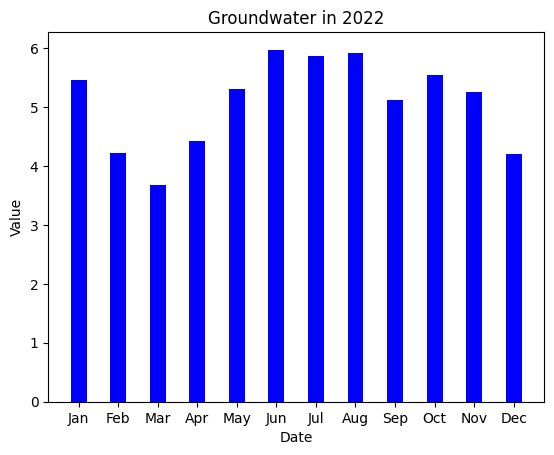

In [68]:
# Get monthly data at a station over a year
import numpy as np
import matplotlib.pyplot as plt
MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

# MODIFY THESE
state = "VT"
start_date = "2022"
end_date = "2022"
index_of_site = 1

data = get_usgs_gw1(state, start_date, end_date)
print('data in %s' % (state))
print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
graph = show_site_data(data, index_of_site, True)
month_data = [0,0,0,0,0,0,0,0,0,0,0,0]
month_data_2 = [0,0,0,0,0,0,0,0,0,0,0,0]
# Organize data into months
for i in range(len(graph)):
    month_data[int(list(graph.keys())[i][5:7]) - 1] += float(list(graph.values())[i])
    month_data_2[int(list(graph.keys())[i][5:7]) - 1] += 1
for i in range(12):
    month_data[int(list(graph.keys())[i][5:7]) - 1] /= month_data_2[int(list(graph.keys())[i][5:7]) - 1]
plt.bar(MONTHS, month_data, color = "blue", width = 0.4)
mean = sum(list(graph.values())) / len(list(graph.values()))
print(f"Mean = {mean:.2f}")
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Groundwater in %s" % (start_date))
plt.show()



data in NY
Site: N  6702. 1   [40.58805556, -73.7179167]


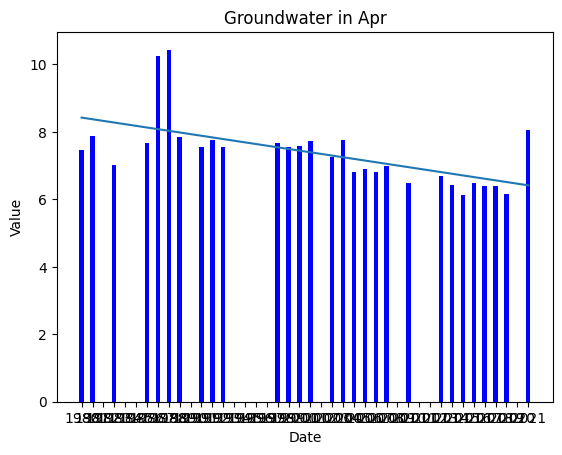

In [125]:
# Get trend over years for the same month, same station

import numpy as np
import matplotlib.pyplot as plt

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', "Dec"]

# MODIFY THESE
state = "NY"
start_date = "1980"
end_date = "2022"
month = "Apr"
index_of_site = 5
data = get_usgs_gw1(state, start_date, end_date)
print('data in %s' % (state))
print(f"Site: {get_site(data, index_of_site)}   {get_coordinates(data, index_of_site)}")
graph = show_site_data(data, index_of_site, False)
values = {}
accumulator = []
for y in range(int(end_date) - int(start_date)):
    accumulator.append(1)
    values[str(int(start_date) + y)] = 0


for date in graph.keys():
    year = date[0:4]
    month2 = int(date[5:7])
    if month2 == (MONTHS.index(month) + 1):
        if year in values:
            values[year] += graph[date]
            accumulator[int(year) - int(start_date)] += 1
for y in range(int(end_date) - int(start_date)):
    if str(y + int(start_date)) in values:
        values[str(y + int(start_date))] /= accumulator[y]

#remove zeros for line of best fit
lst = [range(int(end_date) - int(start_date)), list(values.values())]
lst2 = []
lst3 = []

for j in range(int(end_date) - int(start_date)):
    if lst[1][j] != 0:
        lst2.append(lst[0][j])
        lst3.append(lst[1][j])
x = np.array(lst2)
y = np.array(lst3)
#find line of best fit
a, b = np.polyfit(x, y, 1)
#add points to plot
#add line of best fit to plot
plt.plot(x, a*x+b)   
plt.bar(values.keys(), values.values(), color = "blue", width = 0.4)
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Groundwater in %s" % (month))
plt.show()



